In [1]:
# ## 1. Import libraries and load data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load training dataset
df = pd.read_csv("data/train.csv")

In [2]:
# ## Drop identifier column 'id'
# Removes the 'id' column to avoid leakage / useless features in modeling.

if 'id' in df.columns:
    df = df.drop(columns=['id'])
    print("'id' dropped. New shape:", df.shape)
elif df.index.name == 'id':
    # If 'id' was set as the index, reset and then drop
    df = df.reset_index(drop=True)
    print("'id' was index; reset_index done. New shape:", df.shape)
else:
    print("No 'id' column found (and not used as index).")


'id' dropped. New shape: (188318, 131)


In [3]:
# ## X und y definieren (alle Features außer 'loss')
target = "loss"
assert target in df.columns, "Spalte 'loss' fehlt in df."

y = df[target]                  # Zielvariable
X = df.drop(columns=[target])   # alle übrigen Spalten als Features

print("X shape:", X.shape, "| y shape:", y.shape)


X shape: (188318, 130) | y shape: (188318,)


# Train test split

In [4]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [5]:
# ## 5. Zero variance features (learn on X_train, apply to both train/test)

# Identify zero-variance columns on TRAIN only
zero_var = [col for col in X_train.columns if X_train[col].nunique(dropna=False) <= 1]
print("Zero-variance features (from train):", zero_var)

# Drop the same columns from TRAIN (and TEST if available)
X_train = X_train.drop(columns=zero_var, errors="ignore")
if "X_test" in globals():
    X_test = X_test.drop(columns=zero_var, errors="ignore")

print("Shapes -> X_train:", X_train.shape, "| X_test:", X_test.shape if "X_test" in globals() else "n/a")


Zero-variance features (from train): []
Shapes -> X_train: (150654, 130) | X_test: (37664, 130)


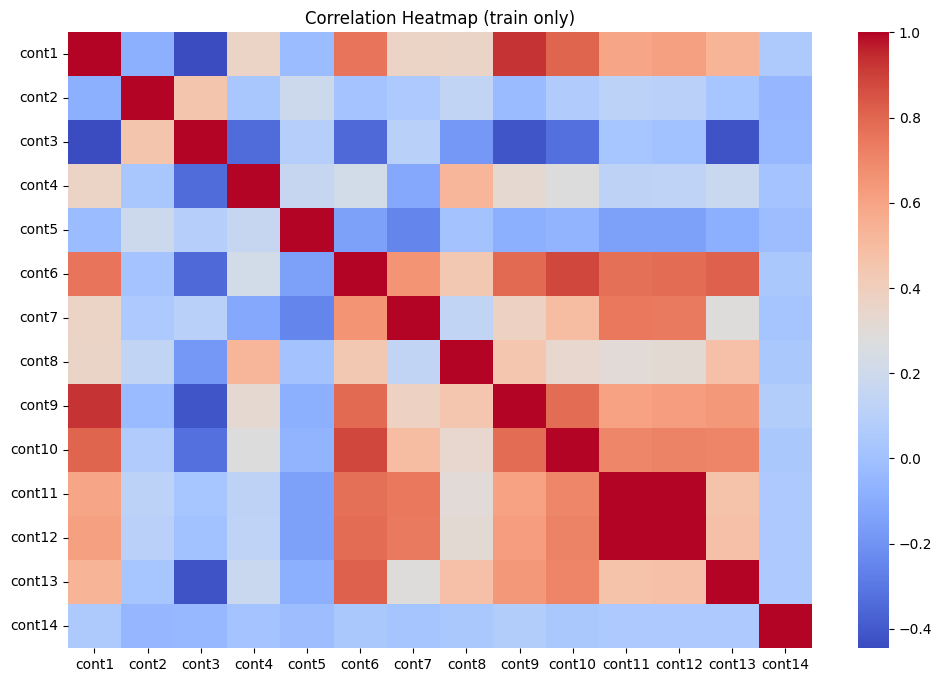

In [6]:
# ## 6. Correlation matrix on X_train (numeric features only)

# Compute correlation on TRAIN numerics only (avoids leakage)
corr = X_train.corr(numeric_only=True)

# Heatmap to visualize correlations
plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap (train only)")
plt.show()


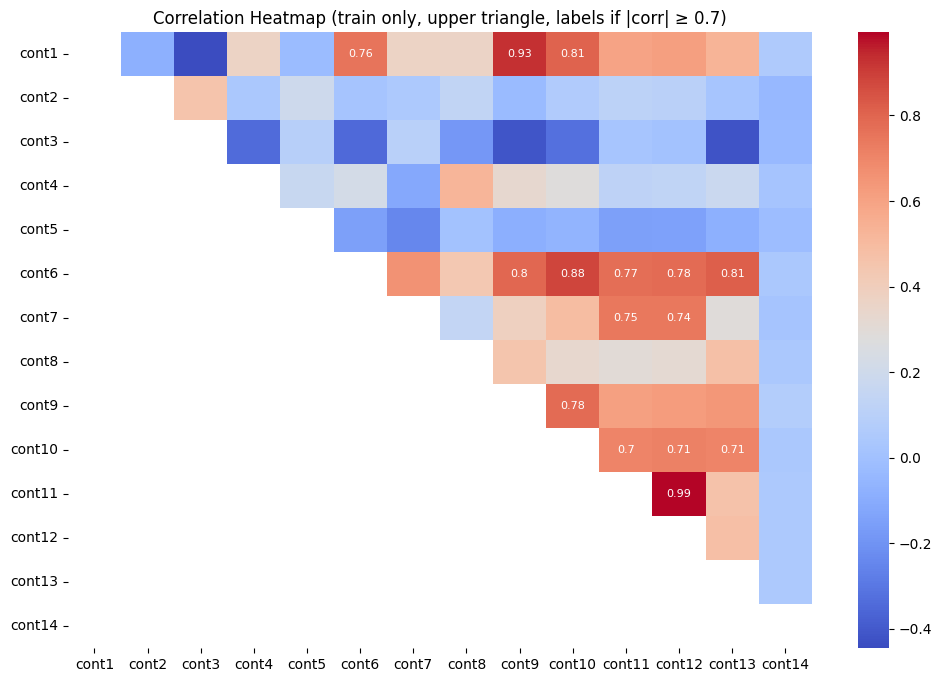

In [7]:
# ## 6b. Correlation heatmap (upper triangle, annotate strong values) on X_train

# Thresholded labels keep the plot readable; only |corr| >= 0.7 are shown
threshold = 0.7
corr = X_train.corr(numeric_only=True)

# Build annotation array: show value if above threshold, else blank
annot = corr.round(2).astype(str).mask(corr.abs() < threshold, "")

# Mask lower triangle to avoid duplicates
mask = np.tril(np.ones(corr.shape), k=0).astype(bool)

plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap="coolwarm", mask=mask, annot=annot, fmt="", annot_kws={"size":8})
plt.title(f"Correlation Heatmap (train only, upper triangle, labels if |corr| ≥ {threshold})")
plt.show()


In [8]:
# ## 7. Detect multicollinearity (VIF) on X_train (train-only, no row drop)

from sklearn.impute import SimpleImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Use only numeric columns from TRAIN
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

# Median-impute numerics for VIF calculation ONLY (avoids dropping rows)
imp = SimpleImputer(strategy="median")
X_vif = pd.DataFrame(imp.fit_transform(X_train[num_cols]), columns=num_cols, index=X_train.index)

# Compute VIF per feature
vif_data = pd.DataFrame({
    "feature": X_vif.columns,
    "VIF": [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
}).sort_values("VIF", ascending=False)

display(vif_data)



,feature,VIF
11,cont12,639.906337
10,cont11,620.636636
5,cont6,135.874356
0,cont1,94.475253
8,cont9,88.559464
9,cont10,57.308215
12,cont13,35.215185
6,cont7,30.516679
7,cont8,14.498653
2,cont3,14.084146


In [9]:
# ## Find features collinear with cont12

# Correlation of cont12 with all other numeric features
corr_with_cont12 = X_train.corr(numeric_only=True)['cont12'].sort_values(ascending=False)

# Show top correlations
print(corr_with_cont12.head(10))
print(corr_with_cont12.tail(10))


cont12    1.000000
cont11    0.994369
cont6     0.784550
cont7     0.742557
cont10    0.713273
cont9     0.626101
cont1     0.613556
cont13    0.477018
cont8     0.314358
cont4     0.130324
Name: cont12, dtype: float64
cont10    0.713273
cont9     0.626101
cont1     0.613556
cont13    0.477018
cont8     0.314358
cont4     0.130324
cont2     0.105527
cont14    0.049242
cont3     0.005459
cont5    -0.146701
Name: cont12, dtype: float64


In [10]:
from sklearn.linear_model import LinearRegression

Z = X_train.drop(columns=['cont12']).select_dtypes(include=[np.number]).dropna()
w = X_train['cont12'].dropna()

model = LinearRegression().fit(Z, w)
r2 = model.score(Z, w)

print("R^2 of cont12 regressed on all other features:", r2)


R^2 of cont12 regressed on all other features: 0.9897799566958149


In [11]:
# ## Identify highly correlated feature pairs (threshold = 0.98)

# Compute correlation matrix
corr_matrix = X_train.corr(numeric_only=True).abs()

# Select upper triangle of correlation matrix (to avoid duplicates)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation above threshold
high_corr_pairs = [
    (col, row, upper.loc[row, col])
    for col in upper.columns
    for row in upper.index
    if upper.loc[row, col] > 0.98
]

# Display results
for f1, f2, corr_val in high_corr_pairs:
    print(f"{f1} ↔ {f2} | correlation = {corr_val:.3f}")


cont12 ↔ cont11 | correlation = 0.994


In [12]:
# ## Drop 'cont12' from TRAIN and TEST

cols_to_drop = ["cont12"]

# Drop from X_train
before_tr = X_train.shape[1]
X_train = X_train.drop(columns=cols_to_drop, errors="ignore")
after_tr = X_train.shape[1]

# Drop from X_test (if it exists)
if "X_test" in globals():
    before_te = X_test.shape[1]
    X_test = X_test.drop(columns=cols_to_drop, errors="ignore")
    after_te = X_test.shape[1]
    print(f"Dropped from X_train: {before_tr - after_tr} col | from X_test: {before_te - after_te} col")
else:
    print(f"Dropped from X_train: {before_tr - after_tr} col | X_test not defined yet")

# Sanity checks
assert "cont12" not in X_train.columns
if "X_test" in globals():
    assert "cont12" not in X_test.columns


print("Remaining features in X_train:", X_train.shape[1])




Dropped from X_train: 1 col | from X_test: 1 col
Remaining features in X_train: 129


In [13]:
# ## 7. Detect multicollinearity (VIF) on X_train (train-only, no row drop)

# Use only numeric columns from TRAIN
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

# Median-impute numerics for VIF calculation ONLY (avoids dropping rows)
imp = SimpleImputer(strategy="median")
X_vif = pd.DataFrame(imp.fit_transform(X_train[num_cols]), columns=num_cols, index=X_train.index)

# Compute VIF per feature
vif_data = pd.DataFrame({
    "feature": X_vif.columns,
    "VIF": [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
}).sort_values("VIF", ascending=False)

display(vif_data)

,feature,VIF
5,cont6,134.853485
0,cont1,94.458375
8,cont9,88.375119
9,cont10,57.307679
11,cont13,35.027625
6,cont7,30.466273
10,cont11,26.372908
7,cont8,14.410907
2,cont3,14.084016
3,cont4,11.011454


In [14]:
# ## Find features collinear with cont6

# Correlation of cont6 with all other numeric features
corr_with_cont6 = X_train.corr(numeric_only=True)['cont6'].sort_values(ascending=False)

# Show top correlations
print(corr_with_cont6.head(10))
print(corr_with_cont6.tail(10))

cont6     1.000000
cont10    0.883358
cont13    0.814393
cont9     0.796622
cont11    0.773128
cont1     0.757663
cont7     0.659185
cont8     0.435863
cont4     0.219420
cont14    0.040798
Name: cont6, dtype: float64
cont9     0.796622
cont11    0.773128
cont1     0.757663
cont7     0.659185
cont8     0.435863
cont4     0.219420
cont14    0.040798
cont2     0.016578
cont5    -0.149352
cont3    -0.348852
Name: cont6, dtype: float64


### we keep cont 6, since advanced models later can deal with these levels of collinearity

### Near constants for a lot of the categorial variables

In [15]:
# ## 8. Detect near-zero variance categorical features (X_train)

# For categorical columns: ratio of most frequent value (train-only)
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns

for col in cat_cols:
    vc = X_train[col].value_counts(normalize=True, dropna=True)
    if len(vc) == 0:
        continue  # skip columns that are entirely NaN
    top_freq = vc.iloc[0]
    if top_freq > 0.95:  # 95%+ same value → low information
        print(f"{col}: {top_freq:.2%} same value")


cat7: 97.58% same value
cat14: 98.78% same value
cat15: 99.98% same value
cat16: 96.57% same value
cat17: 99.30% same value
cat18: 99.46% same value
cat19: 99.04% same value
cat20: 99.90% same value
cat21: 99.78% same value
cat22: 99.98% same value
cat24: 96.62% same value
cat28: 96.05% same value
cat29: 98.02% same value
cat30: 98.11% same value
cat31: 97.15% same value
cat32: 99.36% same value
cat33: 99.50% same value
cat34: 99.69% same value
cat35: 99.89% same value
cat39: 97.40% same value
cat40: 95.67% same value
cat41: 96.21% same value
cat42: 99.10% same value
cat43: 97.76% same value
cat45: 97.72% same value
cat46: 99.53% same value
cat47: 99.62% same value
cat48: 99.86% same value
cat49: 95.15% same value
cat51: 99.34% same value
cat52: 95.35% same value
cat54: 97.57% same value
cat55: 99.92% same value
cat56: 99.90% same value
cat57: 98.39% same value
cat58: 99.88% same value
cat59: 99.84% same value
cat60: 99.77% same value
cat61: 99.62% same value
cat62: 99.98% same value
c

In [16]:
# ## 8a. Quantify dominance on X_train and bucket by action (train-only)
# We split into: MUST_DROP (≈constant), RARE_BUCKET (very dominant), REVIEW (dominant but milder).

import numpy as np
import pandas as pd

cat_cols = X_train.select_dtypes(include=['object','category']).columns

# Train-only top frequency per categorical column (includes NaN as a category)
top_freq = (
    X_train[cat_cols]
    .apply(lambda s: s.value_counts(normalize=True, dropna=False).iloc[0] if s.notna().any() else np.nan)
    .sort_values(ascending=False)
)

# Thresholds aligned to your results:
# - many around 99.8–100%  → MUST_DROP
# - many around 98–99.8%   → RARE_BUCKET (compress rares)
# - some around 95–98%     → REVIEW (decide later; often compress)
MUST_DROP   = 0.999   # ≥ 99.9%
RARE_BUCKET = 0.98    # ≥ 98% and < 99.9%
REVIEW_LOW  = 0.95    # ≥ 95% and < 98%

must_drop_cols   = top_freq[top_freq >= MUST_DROP].index.tolist()
rare_bucket_cols = top_freq[(top_freq >= RARE_BUCKET) & (top_freq < MUST_DROP)].index.tolist()
review_cols      = top_freq[(top_freq >= REVIEW_LOW)  & (top_freq < RARE_BUCKET)].index.tolist()

print(f"MUST_DROP (≥ {MUST_DROP:.3f}): {len(must_drop_cols)}")
print(f"RARE_BUCKET ([{RARE_BUCKET:.2f}, {MUST_DROP:.3f})): {len(rare_bucket_cols)}")
print(f"REVIEW ([{REVIEW_LOW:.2f}, {RARE_BUCKET:.2f})): {len(review_cols)}")

# (Optional) peek at a few names; full lists can be long
print("\nExamples — MUST_DROP:", must_drop_cols[:10])
print("Examples — RARE_BUCKET:", rare_bucket_cols[:10])
print("Examples — REVIEW:", review_cols[:10])

# Quick table to inspect
summary = top_freq.to_frame('top_freq')
summary['bucket'] = 'keep'
summary.loc[must_drop_cols, 'bucket'] = 'must_drop'
summary.loc[rare_bucket_cols, 'bucket'] = 'rare_bucket'
summary.loc[review_cols, 'bucket'] = 'review'
display(summary.head(30))


MUST_DROP (≥ 0.999): 9
RARE_BUCKET ([0.98, 0.999)): 29
REVIEW ([0.95, 0.98)): 16

Examples — MUST_DROP: ['cat70', 'cat15', 'cat22', 'cat64', 'cat62', 'cat63', 'cat68', 'cat55', 'cat56']
Examples — RARE_BUCKET: ['cat20', 'cat35', 'cat58', 'cat48', 'cat59', 'cat69', 'cat21', 'cat60', 'cat34', 'cat67']
Examples — REVIEW: ['cat43', 'cat45', 'cat7', 'cat89', 'cat54', 'cat39', 'cat31', 'cat24', 'cat16', 'cat76']


,top_freq,bucket
cat70,0.999867,must_drop
cat15,0.999814,must_drop
cat22,0.999781,must_drop
cat64,0.999761,must_drop
cat62,0.999761,must_drop
cat63,0.999595,must_drop
cat68,0.999276,must_drop
cat55,0.999203,must_drop
cat56,0.999044,must_drop
cat20,0.998971,rare_bucket


In [17]:
# ## 8b. Drop truly constant-like categorical columns (X_train & X_test)

# Drop from TRAIN
X_train = X_train.drop(columns=must_drop_cols, errors="ignore")

# Drop from TEST (if present)
if "X_test" in globals():
    X_test = X_test.drop(columns=must_drop_cols, errors="ignore")

print(f"Dropped {len(must_drop_cols)} constant-like categorical columns.")
print("New shapes -> X_train:", X_train.shape, "| X_test:", X_test.shape if 'X_test' in globals() else "n/a")



Dropped 9 constant-like categorical columns.
New shapes -> X_train: (150654, 120) | X_test: (37664, 120)


In [18]:
# ## 8c. Compress rare categories on TRAIN (learn) and apply to TRAIN/TEST
# Columns: rare_bucket_cols + review_cols. Keep levels with >= 1% frequency; others -> "__OTHER__".


MIN_FRAC = 0.01  # adjust if needed

def _learn_keep_set(s: pd.Series, min_frac=MIN_FRAC):
    counts = s.value_counts(normalize=True, dropna=True)
    return set(counts[counts >= min_frac].index)

def _compress_with_keep(s: pd.Series, keep, other="__OTHER__"):
    return s.where(s.isna() | s.isin(keep), other)

# choose target columns present in X_train
cols_to_compress = [c for c in (rare_bucket_cols + review_cols) if c in X_train.columns]

# learn keep sets on TRAIN only
keep_map = {col: _learn_keep_set(X_train[col], MIN_FRAC) for col in cols_to_compress}

# apply to TRAIN
for col, keep in keep_map.items():
    X_train[col] = _compress_with_keep(X_train[col], keep)

# apply to TEST with the SAME keep sets (no re-deciding on test)
if "X_test" in globals():
    for col, keep in keep_map.items():
        if col in X_test.columns:
            X_test[col] = _compress_with_keep(X_test[col], keep)

print(f"Compressed rare levels (<{MIN_FRAC:.0%}) to '__OTHER__' for {len(keep_map)} columns.")



Compressed rare levels (<1%) to '__OTHER__' for 45 columns.


In [19]:
# ## 8d (linear-friendly): One-hot with drop='first' (fit on train, transform test)

from sklearn.preprocessing import OneHotEncoder
import pandas as pd

cat_cols = X_train.select_dtypes(include=['object', 'category']).columns
num_cols = X_train.select_dtypes(include=[np.number]).columns

X_num_tr = X_train[num_cols].copy()
X_cat_tr = X_train[cat_cols].copy()

# If your sklearn >= 1.1, you can still keep min_frequency; the *dropped* level is the first category in encoder.categories_
try:
    ohe_lin = OneHotEncoder(
        drop='first',                 # <— THIS avoids the dummy trap
        handle_unknown='ignore',
        min_frequency=0.01,
        sparse_output=False
    )
except TypeError:
    ohe_lin = OneHotEncoder(
        drop='first',
        handle_unknown='ignore',
        sparse=False
    )

# Fit on TRAIN only
X_cat_tr_ohe = ohe_lin.fit_transform(X_cat_tr)
ohe_cols = ohe_lin.get_feature_names_out(cat_cols)
X_cat_tr_ohe = pd.DataFrame(X_cat_tr_ohe, columns=ohe_cols, index=X_train.index)

X_train_enc = pd.concat([X_num_tr, X_cat_tr_ohe], axis=1)
print("X_train_enc (drop='first'):", X_train_enc.shape)

# Transform TEST with the SAME encoder
if "X_test" in globals():
    X_num_te = X_test[num_cols].copy()
    X_cat_te_ohe = ohe_lin.transform(X_test[cat_cols])
    X_cat_te_ohe = pd.DataFrame(X_cat_te_ohe, columns=ohe_cols, index=X_test.index)
    X_test_enc = pd.concat([X_num_te, X_cat_te_ohe], axis=1)
    print("X_test_enc  (drop='first'):", X_test_enc.shape)



X_train_enc (drop='first'): (150654, 345)


c:\Users\phill\Desktop\Python_Basics\ML_Allstate_claims_group2\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [91, 99, 100, 104, 105, 106] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


X_test_enc  (drop='first'): (37664, 345)


In [20]:
# ## 8e. Drop zero-variance columns AFTER encoding (train-learned, apply to test)
# Even after OHE some columns can be all-zero or all-one; detect on TRAIN only, then drop in both.

# Identify zero-variance columns on TRAIN (post-encoding)
zero_var_after = [c for c in X_train_enc.columns if X_train_enc[c].nunique(dropna=False) <= 1]
print(f"Zero-variance cols (train, post-encode): {len(zero_var_after)}")

# Drop from TRAIN
X_train_enc = X_train_enc.drop(columns=zero_var_after, errors="ignore")

# Drop the same columns from TEST (if available)
if "X_test_enc" in globals():
    X_test_enc = X_test_enc.drop(columns=zero_var_after, errors="ignore")

print("Shapes -> X_train_enc:", X_train_enc.shape, "| X_test_enc:", X_test_enc.shape if "X_test_enc" in globals() else "n/a")


Zero-variance cols (train, post-encode): 0
Shapes -> X_train_enc: (150654, 345) | X_test_enc: (37664, 345)


In [21]:
# ## 8f. Audit: what changed on X_train (kept / dropped / compressed)

import pandas as pd

# If top_freq wasn't kept from step 8a, recompute it on X_train:
try:
    top_freq
except NameError:
    cat_cols = X_train.select_dtypes(include=['object','category']).columns
    top_freq = (
        X_train[cat_cols]
        .apply(lambda s: s.value_counts(normalize=True, dropna=False).iloc[0] if s.notna().any() else float('nan'))
        .sort_values(ascending=False)
    )

summary = []
for col, tf in top_freq.items():
    if 'must_drop_cols' in globals() and col in must_drop_cols:
        status = "dropped_constant_like"
    elif 'rare_bucket_cols' in globals() and 'review_cols' in globals() and (col in rare_bucket_cols or col in review_cols):
        status = "compressed_rare_levels"
    elif 'rare_bucket_cols' in globals() and col in rare_bucket_cols:
        status = "compressed_rare_levels"
    else:
        status = "kept"
    summary.append((col, tf, status))

summary_df = pd.DataFrame(summary, columns=["column","top_freq","action"]).sort_values("top_freq", ascending=False)
summary_df.head(30)  # inspect


,column,top_freq,action
0,cat70,0.999867,dropped_constant_like
1,cat15,0.999814,dropped_constant_like
2,cat22,0.999781,dropped_constant_like
3,cat64,0.999761,dropped_constant_like
4,cat62,0.999761,dropped_constant_like
5,cat63,0.999595,dropped_constant_like
6,cat68,0.999276,dropped_constant_like
7,cat55,0.999203,dropped_constant_like
8,cat56,0.999044,dropped_constant_like
9,cat20,0.998971,compressed_rare_levels


# Base line model

In [28]:
# ## Baseline: LinearRegression on already-split, encoded data

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

ols = LinearRegression()
ols.fit(X_train_enc, y_train)
y_pred = ols.predict(X_test_enc)
print("OLS -> R²={:.4f} | RMSE={:.2f} | MAE={:.2f}".format(
    r2_score(y_test, y_pred),
    mean_squared_error(y_test, y_pred, squared=False),
    mean_absolute_error(y_test, y_pred)
))

OLS -> R²=-19238817015440478208.0000 | RMSE=12529207753908.46 | MAE=75088083043.43


In [27]:
# ## OLS with top-K features via univariate selection (on your encoded X)
# Picks the K columns most correlated with y on TRAIN, then fits OLS on that subset.

from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

K = 100  # try 50, 100, 150 ...

selector = SelectKBest(score_func=f_regression, k=K)
Xtr_sel = selector.fit_transform(X_train_enc, y_train)
Xte_sel = selector.transform(X_test_enc)

ols = LinearRegression()
ols.fit(Xtr_sel, y_train)
y_pred = ols.predict(Xte_sel)

r2   = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae  = mean_absolute_error(y_test, y_pred)
print(f"OLS(top-{K}) -> R²={r2:.4f} | RMSE={rmse:.2f} | MAE={mae:.2f}")

# (Optional) see which columns were kept
kept_cols = X_train_enc.columns[selector.get_support()]
print("Kept features:", len(kept_cols))
# display(kept_cols[:20])


OLS(top-150) -> R²=0.4912 | RMSE=2037.48 | MAE=1306.06
Kept features: 150


In [24]:
# ## OLS with one very simple feature (sanity check)
# Use just the single column with highest |corr| to y on TRAIN.

if isinstance(X_train_enc, pd.DataFrame):
    corr = X_train_enc.corrwith(pd.Series(y_train)).abs().dropna()
    best_col = corr.idxmax()
    Xtr_one = X_train_enc[[best_col]]
    Xte_one = X_test_enc[[best_col]]
else:
    best_col = 0
    Xtr_one = X_train_enc[:, [0]]
    Xte_one = X_test_enc[:, [0]]

ols1 = LinearRegression().fit(Xtr_one, y_train)
yp1 = ols1.predict(Xte_one)

print(f"OLS(one={best_col}) -> R²={r2_score(y_test, yp1):.4f} | "
      f"RMSE={mean_squared_error(y_test, yp1, squared=False):.2f} | "
      f"MAE={mean_absolute_error(y_test, yp1):.2f}")


OLS(one=cat80_D) -> R²=0.2234 | RMSE=2517.28 | MAE=1644.04


# Modeling

### Ridge and K-Fold CV

In [25]:
# ## Fast(er) Ridge with RidgeCV + 3-fold CV
import numpy as np
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

cv = KFold(n_splits=3, shuffle=True, random_state=42)  # 3-fold is plenty for alpha tuning
alphas = np.logspace(-2, 2, 9)  # shrink the grid

ridge_cv = make_pipeline(
    StandardScaler(),                          # helps convergence
    RidgeCV(alphas=alphas, scoring='neg_mean_squared_error', cv=cv)
)
ridge_cv.fit(X_train_enc, y_train)

y_pred = ridge_cv.predict(X_test_enc)
print("Best alpha (RidgeCV):", ridge_cv.named_steps['ridgecv'].alpha_)
print("R²={:.4f} | RMSE={:.2f} | MAE={:.2f}".format(
    r2_score(y_test, y_pred),
    mean_squared_error(y_test, y_pred, squared=False),
    mean_absolute_error(y_test, y_pred)
))



Best alpha (RidgeCV): 31.622776601683793
R²=0.5029 | RMSE=2013.89 | MAE=1293.95


In [26]:
# ## Helper: metric print
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

def report(name, y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{name} -> R²={r2:.4f} | RMSE={rmse:.2f} | MAE={mae:.2f}")


In [28]:
# ## (Optional) Prefilter -> LassoCV faster & stabler (top-K univariate)
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression

K = 200  # try 100–300
sel = SelectKBest(f_regression, k=K).fit(X_train_enc, y_train)
Xtr_k, Xte_k = sel.transform(X_train_enc), sel.transform(X_test_enc)

lasso_k = make_pipeline(
    StandardScaler(),
    LassoCV(alphas=np.logspace(-1, 2, 12), cv=3, max_iter=30000, tol=1e-3, n_jobs=-1, random_state=42)
)
lasso_k.fit(Xtr_k, y_train)
yp = lasso_k.predict(Xte_k)
print("LassoCV(top-K) alpha:", lasso_k.named_steps['lassocv'].alpha_)
print("R²={:.4f} | RMSE={:.2f} | MAE={:.2f}".format(
    r2_score(y_test, yp), mean_squared_error(y_test, yp, squared=False), mean_absolute_error(y_test, yp)
))



LassoCV(top-K) alpha: 0.6579332246575679
R²=0.4996 | RMSE=2020.65 | MAE=1297.11


In [30]:
# ## ElasticNet: fast CV on a subset, then refit on full data

import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# 1) Subsample train for tuning (keeps it fast; adjust size)
rng = np.random.RandomState(42)
sub_n = min(50000, len(X_train_enc))   # try 50k; reduce to 30k if still slow
idx = rng.choice(len(X_train_enc), size=sub_n, replace=False)

Xtr_sub = X_train_enc.iloc[idx] if isinstance(X_train_enc, pd.DataFrame) else X_train_enc[idx]
ytr_sub = y_train.iloc[idx] if hasattr(y_train, "iloc") else y_train[idx]

# 2) CV on subset with stronger alphas + more iters (avoids non-convergence at tiny alphas)
enet_cv = make_pipeline(
    StandardScaler(),
    ElasticNetCV(
        l1_ratio=[0.2, 0.5, 0.8],           # small, sane grid
        alphas=np.logspace(-1, 2, 12),      # 0.1 ... 100 (avoid ultra-small alphas)
        cv=3,
        max_iter=30000,
        tol=1e-3,
        n_jobs=-1
    )
)
enet_cv.fit(Xtr_sub, ytr_sub)

alpha  = enet_cv.named_steps["elasticnetcv"].alpha_
l1r    = enet_cv.named_steps["elasticnetcv"].l1_ratio_
print(f"Chosen by CV (subset): alpha={alpha:.4g}, l1_ratio={l1r}")

# 3) Refit a plain ElasticNet on FULL training data with those hyperparams (one fit)
enet_final = make_pipeline(
    StandardScaler(),
    ElasticNet(alpha=alpha, l1_ratio=l1r, max_iter=30000, tol=1e-3, random_state=42)
)
enet_final.fit(X_train_enc, y_train)

# 4) Test metrics
y_pred = enet_final.predict(X_test_enc)
r2   = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae  = mean_absolute_error(y_test, y_pred)
print(f"ElasticNet (final) -> R²={r2:.4f} | RMSE={rmse:.2f} | MAE={mae:.2f}")



Chosen by CV (subset): alpha=0.1874, l1_ratio=0.8
ElasticNet (final) -> R²=0.5019 | RMSE=2016.00 | MAE=1291.62


In [31]:
# ## 3) HistGradientBoostingRegressor — fast boosting baseline (no scaling needed)
from sklearn.ensemble import HistGradientBoostingRegressor

hgb = HistGradientBoostingRegressor(
    learning_rate=0.1, max_depth=None, max_iter=300, random_state=42,
    early_stopping=True
)
hgb.fit(X_train_enc, y_train)
y_pred = hgb.predict(X_test_enc)
report("HistGradientBoosting", y_test, y_pred)


HistGradientBoosting -> R²=0.5718 | RMSE=1869.22 | MAE=1183.55


In [32]:
# ## 4) Cheap interactions: top-K numeric features + pairwise interactions + RidgeCV (3-fold)
# Uses only the strongest K numeric features to keep it fast.

import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline

# pick top-K numeric features by |corr| with y (train-only, from PRE-ENCODING X_train)
num_cols_orig = X_train.select_dtypes(include=[float, int]).columns
corrs = X_train[num_cols_orig].corrwith(y_train).abs().dropna().sort_values(ascending=False)
K = min(12, len(corrs))  # small K keeps it fast
topK = corrs.head(K).index.tolist()
print("Interactions among:", topK)

# build design from those K numerics only (ignore cats to stay fast)
Xtr_num = X_train[topK].copy()
Xte_num = X_test[topK].copy()

inter_ridge = make_pipeline(
    PolynomialFeatures(degree=2, interaction_only=True, include_bias=False),
    StandardScaler(),
    RidgeCV(alphas=np.logspace(-2, 2, 9), cv=3, scoring='neg_mean_squared_error')
)
inter_ridge.fit(Xtr_num, y_train)
y_pred = inter_ridge.predict(Xte_num)
report("RidgeCV + interactions(top-K numerics)", y_test, y_pred)


Interactions among: ['cont2', 'cont7', 'cont3', 'cont11', 'cont6', 'cont4', 'cont8', 'cont10', 'cont14', 'cont9', 'cont1', 'cont5']
RidgeCV + interactions(top-K numerics) -> R²=0.0427 | RMSE=2794.82 | MAE=1933.43


In [36]:
# ## 1) Decision Tree (quick depth sweep; will overfit if too deep)
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold, cross_val_score
import numpy as np

cv = KFold(n_splits=3, shuffle=True, random_state=42)
depths = [3, 5, 8, 12]

best = None; best_rmse = float("inf")
for d in depths:
    dt = DecisionTreeRegressor(max_depth=d, random_state=42)
    # negative RMSE -> flip sign
    rmse = -cross_val_score(dt, X_train_enc, y_train, cv=cv,
                            scoring="neg_root_mean_squared_error", n_jobs=-1).mean()
    if rmse < best_rmse:
        best_rmse, best = rmse, dt

best.fit(X_train_enc, y_train)
pred = best.predict(X_test_enc)
report(f"DecisionTree(max_depth={best.get_params()['max_depth']})", y_test, pred)


DecisionTree(max_depth=8) -> R²=0.4617 | RMSE=2095.76 | MAE=1370.33


In [37]:
# ## 2) Random Forest (use OOB for quick validation; no CV)
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=300,            # small but solid
    max_depth=None,
    min_samples_leaf=5,          # reduces overfitting, speeds up
    n_jobs=-1, random_state=42,
    oob_score=True, bootstrap=True
)
rf.fit(X_train_enc, y_train)
print("OOB R²:", rf.oob_score_)
pred = rf.predict(X_test_enc)
report("RandomForest", y_test, pred)

# (Optional) most important features
# import pandas as pd
# imp = pd.Series(rf.feature_importances_, index=getattr(X_train_enc, "columns", range(X_train_enc.shape[1])))
# display(imp.sort_values(ascending=False).head(20))


OOB R²: 0.5435454767936849
RandomForest -> R²=0.5567 | RMSE=1901.96 | MAE=1217.17


In [40]:
# ##HistGradientBoostingRegressor
import numpy as np
from sklearn.ensemble import StackingRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import KFold
from sklearn.base import clone

# 1) avoid pandas indexing surprises
Xtr = np.asarray(X_train_enc)
Xte = np.asarray(X_test_enc)

# 2) CV splitter
cv3 = KFold(n_splits=3, shuffle=True, random_state=42)

# 3) three diverse HGB base models
base = HistGradientBoostingRegressor(
    learning_rate=0.08, max_iter=400, early_stopping=True,
    l2_regularization=1e-4
)
estimators = [
    ("hgb_dNone", clone(base).set_params(max_depth=None,  random_state=41)),
    ("hgb_d6",    clone(base).set_params(max_depth=6,     random_state=42)),
    ("hgb_d3",    clone(base).set_params(max_depth=3,     random_state=43)),
]

meta = RidgeCV(alphas=np.logspace(-2, 2, 9), cv=3, scoring="neg_mean_squared_error")

stack = StackingRegressor(
    estimators=estimators,
    final_estimator=meta,
    cv=cv3,            # proper splitter
    passthrough=False  # keep it simple; turn on later if needed
)

stack.fit(Xtr, y_train)
y_pred = stack.predict(Xte)
report("Stacking(3×HGB → RidgeCV)", y_test, y_pred)


Stacking(3×HGB → RidgeCV) -> R²=0.5756 | RMSE=1860.98 | MAE=1182.57


In [39]:
# ## 4) Extra Trees (very fast, strong baseline)
from sklearn.ensemble import ExtraTreesRegressor

et = ExtraTreesRegressor(
    n_estimators=400, max_depth=None, min_samples_leaf=5,
    n_jobs=-1, random_state=42
)
et.fit(X_train_enc, y_train)
pred = et.predict(X_test_enc)
report("ExtraTrees", y_test, pred)


ExtraTrees -> R²=0.5316 | RMSE=1954.89 | MAE=1233.94


In [41]:
# ## 5) Simple blending (ensemble): average the best two models
# Use a quick validation split from train to choose a weight, then refit each on full train and blend on test.

from sklearn.model_selection import train_test_split
import numpy as np

# pick two candidates to blend
m1 = RandomForestRegressor(n_estimators=300, min_samples_leaf=5, n_jobs=-1, random_state=42, oob_score=False)
m2 = HistGradientBoostingRegressor(learning_rate=0.1, max_iter=300, early_stopping=True, random_state=42)

X_bl_tr, X_bl_va, y_bl_tr, y_bl_va = train_test_split(X_train_enc, y_train, test_size=0.2, random_state=42)
m1.fit(X_bl_tr, y_bl_tr); p1 = m1.predict(X_bl_va)
m2.fit(X_bl_tr, y_bl_tr); p2 = m2.predict(X_bl_va)

# try a few weights
weights = [0.0, 0.25, 0.5, 0.75, 1.0]
best_w, best_rmse = None, float("inf")
for w in weights:
    blend = w*p1 + (1-w)*p2
    rmse = mean_squared_error(y_bl_va, blend, squared=False)
    if rmse < best_rmse:
        best_rmse, best_w = rmse, w
print(f"Chosen blend weight w={best_w} (m1 share) on validation")

# refit on full train and evaluate on test
m1.fit(X_train_enc, y_train); t1 = m1.predict(X_test_enc)
m2.fit(X_train_enc, y_train); t2 = m2.predict(X_test_enc)
pred = best_w*t1 + (1-best_w)*t2
report("Blend(RandomForest, HistGB)", y_test, pred)


Chosen blend weight w=0.25 (m1 share) on validation
Blend(RandomForest, HistGB) -> R²=0.5766 | RMSE=1858.75 | MAE=1179.61


In [48]:
# --- Fix & Run BorutaShap (Regression, SHAP) ---

import numpy as np
from BorutaShap import BorutaShap

# Kompatibilitäts-Wrapper für SciPy (binomtest vs. binom_test) + Integer-Cast
try:
    from scipy.stats import binomtest as _binom_test
    def _binom_pvals(array, n, p, alternative):
        arr = np.asarray(array, dtype=int)
        n = int(n)
        return [_binom_test(int(k), n=n, p=p, alternative=alternative).pvalue for k in arr]
except ImportError:
    from scipy.stats import binom_test as _binom_test
    def _binom_pvals(array, n, p, alternative):
        arr = np.asarray(array, dtype=int)
        n = int(n)
        return [_binom_test(int(k), n=n, p=p, alternative=alternative) for k in arr]

# Patch in das Paket injizieren
BorutaShap.binomial_H0_test = staticmethod(_binom_pvals)

# Modell definieren (du kannst deine Hyperparameter beibehalten/ändern)
import lightgbm as lgb
model = lgb.LGBMRegressor(
    n_estimators=300, learning_rate=0.08, num_leaves=31,
    subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1
)

# BorutaShap ausführen (Xtr_df: DataFrame, y_train: Ziel)
fs = BorutaShap(model=model, importance_measure='shap', classification=False)
fs.fit(X=Xtr_df, y=y_train, n_trials=25, sample=False, normalize=True, verbose=False)

# Ausgewählte Features holen
Xtr_sel = fs.Subset()                        # subset des TRAIN mit Keep-Features
selected_cols = list(Xtr_sel.columns)

print(f"{len(selected_cols)} ausgewählte Features:")
print(selected_cols)

# (Optional) Weitere Splits gleich filtern:
# Xval_sel = Xval_df[selected_cols]
# Xtest_sel = Xtest_df[selected_cols]


  0%|          | 0/25 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0,088701 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6070
[LightGBM] [Info] Number of data points in the train set: 105457, number of used features: 684
[LightGBM] [Info] Start training from score 3041,688687
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0,644687 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6080
[LightGBM] [Info] Number of data points in the train set: 105457, number of used features: 685
[LightGBM] [Info] Start training from score 3041,688687
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0,133002 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is

In [55]:
# --- 0) Sicherstellen, dass rgf (rgf-python) installiert ist ---
import sys, subprocess, importlib
def ensure_import(mod, pip_name=None):
    try:
        return importlib.import_module(mod)
    except ModuleNotFoundError:
        if pip_name is None:
            pip_name = mod
        subprocess.check_call([sys.executable, "-m", "pip", "install", pip_name])
        return importlib.import_module(mod)

rgf_sklearn = ensure_import("rgf.sklearn", "rgf-python")
from rgf.sklearn import RGFRegressor

import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error

# --- Validation-Split anlegen, falls nicht vorhanden ---
from sklearn.model_selection import train_test_split
import pandas as pd

if ('Xval_df' not in globals()) or ('y_val' not in globals()):
    # Sicherstellen, dass y und X index-mäßig zueinander passen
    y_train = pd.Series(y_train, index=Xtr_df.index)
    Xtr_df, Xval_df, y_train, y_val = train_test_split(
        Xtr_df, y_train, test_size=0.2, random_state=42
    )
    print(f"Validation split created: train={Xtr_df.shape}, val={Xval_df.shape}")


# --- 1) Selektierte Features aus BorutaShap holen ---
sel = getattr(fs, "accepted", None) or getattr(fs, "accepted_features_", None)
if sel is None or len(sel) == 0:
    raise ValueError("BorutaShap hat keine akzeptierten Features gefunden.")

sel_cols = list(sel)
# Falls BorutaShap Indizes statt Namen liefert:
if len(sel_cols) and not isinstance(sel_cols[0], str):
    sel_cols = [Xtr_df.columns[int(i)] for i in sel_cols]

# --- 2) Spalten über Train/Val(/Test) ausrichten ---
def align_to_cols(df, cols):
    df2 = df.copy()
    for c in cols:
        if c not in df2.columns:
            df2[c] = 0
    return df2.reindex(columns=cols, fill_value=0)

Xtr_sel  = align_to_cols(Xtr_df,  sel_cols)
Xval_sel = align_to_cols(Xval_df, sel_cols)
try:
    Xte_sel = align_to_cols(Xte_df, sel_cols)
except NameError:
    Xte_sel = None

# --- 3) (Optional) Log-Transform des Targets ---
use_log = True
y_tr = np.log1p(y_train) if use_log else y_train

# --- 4) RGF trainieren ---
rgf = RGFRegressor(
    loss="LS",
    algorithm="RGF_Sib",
    max_leaf=3000,
    l2=1.0,
    min_samples_leaf=20,
    n_iter=100,
    normalize=True,
    )
rgf.fit(Xtr_sel.values, y_tr)

# --- 5) Validierung ---
y_pred = rgf.predict(Xval_sel.values)
if use_log:
    y_pred = np.expm1(y_pred)

val_mae = mean_absolute_error(y_val, y_pred)
print("Val MAE (RGF auf Boruta-SHAP-Features):", round(val_mae, 4))

# --- 6) Optional: Test ---
if Xte_sel is not None:
    y_test_pred = rgf.predict(Xte_sel.values)
    if use_log:
        y_test_pred = np.expm1(y_test_pred)
    # Beispiel: speichern
    # pd.Series(y_test_pred, index=Xte_sel.index).to_csv("rgf_predictions.csv", index=False)



Val MAE (RGF auf Boruta-SHAP-Features): 1186.6612


In [56]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# ===== Eingaben vorausgesetzt: Xtr_df, y_train, Xval_df, y_val =====
# Falls Series/DataFrames: sicher als np.array
y_tr_log = np.log1p(y_train)

# --- Modelle (nimm gern deine bisherigen Hyperparameter) ---
rf = RandomForestRegressor(
    n_estimators=300, max_features='sqrt', n_jobs=-1, random_state=42
)
hgb = HistGradientBoostingRegressor(
    max_iter=300, learning_rate=0.08, max_leaf_nodes=31,
    early_stopping=True, random_state=42
)

# --- Training auf log1p-Target ---
rf.fit(Xtr_df, y_tr_log)
hgb.fit(Xtr_df, y_tr_log)

# --- Vorhersagen (Train für Smearing, Val für Metriken) ---
rf_log_tr  = rf.predict(Xtr_df)
hgb_log_tr = hgb.predict(Xtr_df)

rf_log_val  = rf.predict(Xval_df)
hgb_log_val = hgb.predict(Xval_df)

# --- Retransformation: exmp1 oder (optional) Duan-Smearing ---
use_smearing = True

if use_smearing:
    S_rf  = float(np.mean(np.exp(y_tr_log - rf_log_tr)))
    S_hgb = float(np.mean(np.exp(y_tr_log - hgb_log_tr)))
    rf_val  = S_rf  * np.exp(rf_log_val)  - 1.0
    hgb_val = S_hgb * np.exp(hgb_log_val) - 1.0
else:
    rf_val  = np.expm1(rf_log_val)
    hgb_val = np.expm1(hgb_log_val)

rf_val  = np.asarray(rf_val)
hgb_val = np.asarray(hgb_val)
yv      = np.asarray(y_val)

# --- Optimales Blend-Gewicht (für MSE/RMSE) analytisch ---
def best_w_mse(y, a, b):
    d = a - b
    denom = float(np.dot(d, d))
    if denom == 0.0:
        return 0.5
    w = float(np.dot(y - b, d) / denom)
    return float(np.clip(w, 0.0, 1.0))

w_star = best_w_mse(yv, rf_val, hgb_val)

# --- Blends & Metriken ---
def metrics(y, yhat):
    rmse = mean_squared_error(y, yhat, squared=False)
    mae  = mean_absolute_error(y, yhat)
    r2   = r2_score(y, yhat)
    return r2, rmse, mae

# optimaler Blend
blend_star = w_star * rf_val + (1.0 - w_star) * hgb_val
r2_s, rmse_s, mae_s = metrics(yv, blend_star)

# Vergleich: dein altes w=0.25 (RF-Anteil)
w_old = 0.25
blend_old = w_old * rf_val + (1.0 - w_old) * hgb_val
r2_o, rmse_o, mae_o = metrics(yv, blend_old)

print(f"Chosen blend weight w={w_star:.4f} (RF share) on validation")
print(f"Blend(RF, HistGB, log-target) -> R²={r2_s:.4f} | RMSE={rmse_s:.2f} | MAE={mae_s:.2f}")
print(f"[w=0.25] -> R²={r2_o:.4f} | RMSE={rmse_o:.2f} | MAE={mae_o:.2f}")


Chosen blend weight w=0.0571 (RF share) on validation
Blend(RF, HistGB, log-target) -> R²=0.5527 | RMSE=1967.07 | MAE=1185.29
[w=0.25] -> R²=0.5488 | RMSE=1975.48 | MAE=1174.45


In [58]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Voraussetzung: yv (y_val), rf_val, hgb_val sind bereits auf ORIGINALSKALA
# (also nach exmp1 bzw. Smearing rücktransformiert!)

def best_w_mae_grid(y, a, b, coarse=0.01, fine=0.001, window=0.03):
    # Grobe Suche
    ws  = np.arange(0.0, 1.0 + coarse, coarse)
    maes = [mean_absolute_error(y, w*a + (1-w)*b) for w in ws]
    w0 = float(ws[int(np.argmin(maes))])

    # Feinsuche um das Minimum herum
    wL = max(0.0, w0 - window)
    wU = min(1.0, w0 + window)
    ws2  = np.arange(wL, wU + fine, fine)
    maes2 = [mean_absolute_error(y, w*a + (1-w)*b) for w in ws2]
    w_star = float(ws2[int(np.argmin(maes2))])
    return w_star

w_mae = best_w_mae_grid(yv, rf_val, hgb_val)
blend_mae = w_mae * rf_val + (1 - w_mae) * hgb_val

print(f"Best w (MAE) = {w_mae:.4f}")
print("R²={:.4f} | RMSE={:.2f} | MAE={:.2f}".format(
    r2_score(yv, blend_mae),
    mean_squared_error(yv, blend_mae, squared=False),
    mean_absolute_error(yv, blend_mae),
))


Best w (MAE) = 0.3960
R²=0.5408 | RMSE=1992.91 | MAE=1172.10


In [66]:
# XGBoost auf ALLEN Features (ohne FS), MAE-Optimierung, robust über XGB 1.x/2.x
# Voraussetzungen: Xtr_df, y_train, Xval_df, y_val  (Pandas, numerisch encodiert)

import numpy as np
import pandas as pd
import random, warnings, inspect
from xgboost import XGBRegressor, __version__ as xgb_version
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

# ---------- 0) Spalten ausrichten (falls Val/Test Dummies fehlen) ----------
def align_to_cols(df_ref: pd.DataFrame, df_to_fix: pd.DataFrame) -> pd.DataFrame:
    df2 = df_to_fix.copy()
    missing = [c for c in df_ref.columns if c not in df2.columns]
    for c in missing:
        df2[c] = 0
    # Extraspalten in Val, die Train nicht hat, verwerfen:
    df2 = df2.reindex(columns=df_ref.columns, fill_value=0)
    return df2

Xval_all = align_to_cols(Xtr_df, Xval_df)

# Optional: Nur numerische Spalten verwenden (Fehler robust umgehen)
num_cols = Xtr_df.select_dtypes(include=[np.number, "bool"]).columns
if len(num_cols) != Xtr_df.shape[1]:
    warnings.warn(
        f"{Xtr_df.shape[1] - len(num_cols)} nicht-numerische Spalten in Xtr_df gefunden – sie werden ignoriert."
    )
Xtr_all  = Xtr_df[num_cols].astype(float)
Xval_all = Xval_all[num_cols].astype(float)

# ---------- 1) MAE-Ziel + optionales Log-Target ----------
use_log = True  # bei stark rechtsschiefen Targets ggf. auf True setzen
y_tr = np.log1p(y_train) if use_log else y_train
y_va = np.log1p(y_val)   if use_log else y_val

# ---------- 2) Fit-Signatur prüfen (für Early Stopping / eval_metric / verbose) ----------
fit_sig_params = inspect.signature(XGBRegressor().fit).parameters
supports_callbacks          = "callbacks" in fit_sig_params
supports_es_rounds_in_fit   = "early_stopping_rounds" in fit_sig_params
supports_eval_metric_in_fit = "eval_metric" in fit_sig_params
supports_verbose_in_fit     = "verbose" in fit_sig_params

# ---------- 3) Param-Space (kleine Random-Search für Speed) ----------
param_space = {
    "max_depth":        [3, 4, 5, 6],
    "min_child_weight": [1, 2, 5],
    "subsample":        [0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.7, 0.8, 0.9, 1.0],
    "gamma":            [0, 0.5],
    "reg_alpha":        [0.0, 0.01, 0.1],
    "reg_lambda":       [0.5, 1.0, 2.0],
    "learning_rate":    [0.03, 0.05, 0.07, 0.1],
}

def sample_params(space, n=18, seed=42):
    rng = random.Random(seed)
    keys = list(space.keys())
    return [{k: rng.choice(space[k]) for k in keys} for _ in range(n)]

trials = sample_params(param_space, n=18, seed=42)

# Gemeinsame Defaults – bewusst 'reg:squarederror' für maximale Kompatibilität
common = dict(
    objective="reg:squarederror",  # sicher in 1.x und 2.x
    tree_method="hist",            # schnell; falls GPU verfügbar -> "gpu_hist"
    n_estimators=4000,             # hoch + Early Stopping
    n_jobs=-1,
    random_state=42,
    verbosity=0
)

# ---------- 4) Training + Early Stopping (robust je nach Version) ----------
best = {"mae": np.inf, "params": None, "model": None, "scores": None}

for i, p in enumerate(trials, 1):
    # eval_metric möglichst in den Konstruktor setzen (funktioniert in 1.x/2.x)
    model = XGBRegressor(eval_metric="mae", **common, **p)

    if supports_callbacks:
        # Neuer Weg: via callbacks (XGB 2.x und manche 1.x)
        try:
            from xgboost.callback import EarlyStopping
            model.fit(
                Xtr_all, y_tr,
                eval_set=[(Xval_all, y_va)],
                callbacks=[EarlyStopping(rounds=150, save_best=True)]
            )
        except TypeError:
            # Fallback, falls callbacks doch nicht akzeptiert werden
            kw = dict(eval_set=[(Xval_all, y_va)])
            if supports_eval_metric_in_fit:
                kw["eval_metric"] = "mae"
            if supports_es_rounds_in_fit:
                kw["early_stopping_rounds"] = 150
            if supports_verbose_in_fit:
                kw["verbose"] = False
            model.fit(Xtr_all, y_tr, **kw)
    else:
        # Alter Weg: eval_metric + early_stopping_rounds direkt in fit
        kw = dict(eval_set=[(Xval_all, y_va)])
        if supports_eval_metric_in_fit:
            kw["eval_metric"] = "mae"
        if supports_es_rounds_in_fit:
            kw["early_stopping_rounds"] = 150
        if supports_verbose_in_fit:
            kw["verbose"] = False
        model.fit(Xtr_all, y_tr, **kw)

    # Vorhersage (ggf. Rücktransformation)
    z_hat = model.predict(Xval_all)
    y_pred = np.expm1(z_hat) if use_log else z_hat

    mae  = mean_absolute_error(y_val, y_pred)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    r2   = r2_score(y_val, y_pred)

    if mae < best["mae"]:
        best.update({"mae": mae, "params": p, "model": model, "scores": (r2, rmse, mae)})

    print(f"[{i:02d}/{len(trials)}] MAE={mae:.3f} | RMSE={rmse:.1f} | R²={r2:.4f}  <- {p}")

# ---------- 5) Resultate ----------
print("\nBestes XGB (nach MAE) – ohne FS, alle Features")
print(best["params"])
r2, rmse, mae = best["scores"]
print(f"R²={r2:.4f} | RMSE={rmse:.1f} | MAE={mae:.2f} | XGBoost {xgb_version} | Log-Target={use_log}")

best_model = best["model"]
# Beispiel-Predictions (Originalskala):
y_val_pred = best_model.predict(Xval_all)
if use_log:
    y_val_pred = np.expm1(y_val_pred)



[01/18] MAE=1166.120 | RMSE=1997.9 | R²=0.5385  <- {'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.9, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0.0, 'reg_lambda': 2.0, 'learning_rate': 0.03}
[02/18] MAE=1167.595 | RMSE=2001.9 | R²=0.5367  <- {'max_depth': 3, 'min_child_weight': 5, 'subsample': 1.0, 'colsample_bytree': 0.7, 'gamma': 0, 'reg_alpha': 0.0, 'reg_lambda': 0.5, 'learning_rate': 0.05}
[03/18] MAE=1164.772 | RMSE=1988.5 | R²=0.5429  <- {'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 0, 'reg_alpha': 0.01, 'reg_lambda': 2.0, 'learning_rate': 0.07}
[04/18] MAE=1174.033 | RMSE=2025.3 | R²=0.5258  <- {'max_depth': 3, 'min_child_weight': 1, 'subsample': 1.0, 'colsample_bytree': 0.9, 'gamma': 0.5, 'reg_alpha': 0.0, 'reg_lambda': 0.5, 'learning_rate': 0.07}
[05/18] MAE=1174.084 | RMSE=2024.4 | R²=0.5262  <- {'max_depth': 3, 'min_child_weight': 1, 'subsample': 1.0, 'colsample_bytree': 0.7, 'gamma': 0.5, 'reg_alpha': 0.01, 'reg_l

In [67]:
# FINAL: bestes XGB neu auf TRAIN+VAL fitten, speichern und später für neue Testdaten nutzen
# Voraussetzungen aus deinem Lauf:
# - best["model"]  (das validierungs-beste Modell)
# - best["params"] (beste Param-Kombi aus der Suche)
# - Xtr_all, Xval_all (alle Features, numerisch, spalten-ausgerichtet)
# - y_train, y_val (Originalskala)
# - use_log (True/False)
# HINWEIS: Wenn du Xtr_all/Xval_all nicht mehr im RAM hast, bau sie identisch wieder auf.

import numpy as np, pandas as pd, json, joblib
from xgboost import XGBRegressor, __version__ as xgb_version

# --- 1) Full data zusammenstellen (im selben Feature-Raum) ---
X_full = pd.concat([Xtr_all, Xval_all], axis=0)
y_full = pd.concat([y_train, y_val], axis=0)
y_full_tr = np.log1p(y_full) if use_log else y_full

# --- 2) Beste Parametrisierung aus dem validierten Modell holen ---
best_model = best["model"]
params_used = best_model.get_xgb_params().copy()

# Falls Early Stopping aktiv war: best_iteration verwenden
best_iter = getattr(best_model, "best_iteration", None)
if best_iter is not None and best_iter > 0:
    params_used["n_estimators"] = int(best_iter)

# Sicherheits-Defaults:
params_used.setdefault("objective", "reg:squarederror")
params_used.setdefault("tree_method", "hist")
params_used.setdefault("n_jobs", -1)
params_used.setdefault("random_state", 42)

# --- 3) Finales Modell auf TRAIN+VAL fitten (ohne eval_set) ---
final_model = XGBRegressor(**params_used)
final_model.fit(X_full, y_full_tr)

# --- 4) (Optional) Duan-Smearing-Faktor für Log-Target schätzen ---
smear = 1.0
if use_log:
    z_hat_full = final_model.predict(X_full)
    smear = float(np.mean(np.exp(y_full_tr - z_hat_full)))  # E[exp(resid)]

# --- 5) Artefakte speichern ---
final_model_path   = "xgb_final.pkl"                    # sklearn-Wrapper
booster_json_path  = "xgb_final_booster.json"           # Booster (versionstabil)
columns_path       = "xgb_columns.txt"                  # Spaltenreihenfolge
meta_path          = "xgb_meta.json"                    # Meta-Infos

joblib.dump(final_model, final_model_path)
final_model.get_booster().save_model(booster_json_path)
pd.Series(X_full.columns).to_csv(columns_path, index=False, header=False)
with open(meta_path, "w", encoding="utf-8") as f:
    json.dump({
        "use_log": bool(use_log),
        "smear": float(smear),
        "xgboost_version": xgb_version,
        "params_used": params_used
    }, f, indent=2)

print("Gespeichert:", final_model_path, booster_json_path, columns_path, meta_path)

# --- 6) Hilfsfunktionen für zukünftige Nutzung auf NEUEN Testdaten ---
def load_artifacts(prefix="xgb_"):
    model   = joblib.load("xgb_final.pkl")
    with open("xgb_meta.json", "r", encoding="utf-8") as f:
        meta = json.load(f)
    cols = pd.read_csv("xgb_columns.txt", header=None).iloc[:,0].tolist()
    return model, cols, meta

def align_to_cols(df, cols):
    df2 = df.copy()
    missing = [c for c in cols if c not in df2.columns]
    for c in missing:
        df2[c] = 0
    return df2.reindex(columns=cols, fill_value=0)

def predict_on_new(df_new: pd.DataFrame):
    model, cols, meta = load_artifacts()
    X_new = align_to_cols(df_new, cols).astype(float)
    z = model.predict(X_new)
    if meta["use_log"]:
        y_hat = np.expm1(z) * float(meta.get("smear", 1.0))
    else:
        y_hat = z
    return pd.Series(y_hat, index=X_new.index, name="prediction")

# Beispiel:
# new_preds = predict_on_new(Xte_df)
# new_preds.to_csv("xgb_preds_test.csv", index=False)


Gespeichert: xgb_final.pkl xgb_final_booster.json xgb_columns.txt xgb_meta.json


In [79]:
# ===================== XGB K-Fold CV (OOF) + optional RGF =====================
# Voraussetzungen: vorverarbeitete Trainingsdaten als Pandas:
#   - Xtr_df, y_train  (und optional Xval_df, y_val -> werden zu X_all/y_all zusammengeführt)
# Nutzt dein bestes Param-Set:
#   {'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.8, 'colsample_bytree': 0.7,
#    'gamma': 0.5, 'reg_alpha': 0.01, 'reg_lambda': 1.0, 'learning_rate': 0.03}
#
# Hinweise:
# - Kein Early Stopping (kompatibel mit deiner XGBoost-Version). Wähle n_estimators konservativ.
# - Log-Target + Duan-Smearing pro Fold korrekt angewandt.
# - Speichert Fold-Modelle + Meta (Smearing je Fold) für spätere Nutzung/Blends.

import os, json, pickle
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import xgboost as xgb
from xgboost import XGBRegressor, __version__ as xgb_version

# ---------------- Config ----------------
N_FOLDS      = 5
N_ESTIMATORS = 700        # konservativ ohne Early Stopping (bei Bedarf erhöhen/reduzieren)
RANDOM_STATE = 42
USE_LOG      = True        # wie bei dir
USE_SMEARING = True

SAVE_DIR = Path("./cv_artifacts_xgb")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

BEST_PARAMS = {
    "max_depth": 5,
    "min_child_weight": 1,
    "subsample": 0.8,
    "colsample_bytree": 0.7,
    "gamma": 0.5,
    "reg_alpha": 0.01,
    "reg_lambda": 1.0,
    "learning_rate": 0.03,
}

# Optionale weitere Regularisierung (einfach mal testen):
BEST_PARAMS.update({
     "colsample_bylevel": 0.9,
     "colsample_bynode": 0.9,
     "grow_policy": "lossguide",  # nur mit tree_method="hist" stabil nutzen
     "max_leaves": 64,
     "max_bin": 64,
})

def parse_ver(v):
    try:
        major, minor, *_ = v.split("+")[0].split(".")
        return (int(major), int(minor))
    except Exception:
        return (1, 7)

XGB_MM = parse_ver(xgb_version)
OBJECTIVE = "reg:absoluteerror" if XGB_MM >= (2, 0) else "reg:squarederror"

# ---------------- Daten zusammenführen ----------------
def build_Xy_for_cv():
    # Nutzt train + val, falls vorhanden; sonst nur train
    if "Xval_df" in globals() and "y_val" in globals() and len(Xval_df) == len(y_val):
        X_all = pd.concat([Xtr_df, Xval_df], axis=0)
        y_all = pd.concat([y_train, y_val], axis=0)
    else:
        X_all, y_all = Xtr_df.copy(), y_train.copy()
    return X_all, y_all

X_all, y_all = build_Xy_for_cv()
assert isinstance(X_all, pd.DataFrame) and len(X_all) == len(y_all)

# ---------------- Helper: log/exp mit Smearing ----------------
def to_log(y):
    return np.log1p(y) if USE_LOG else y

def from_log(z, smear=1.0):
    if USE_LOG:
        out = np.expm1(z)
        if USE_SMEARING:
            out = out * smear
        return out
    return z

# ---------------- K-Fold Training ----------------
kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

oof_pred = np.zeros(len(X_all), dtype=float)
fold_smears = []
fold_models = []
fold_scores = []

common = dict(
    objective=OBJECTIVE,
    n_estimators=N_ESTIMATORS,
    tree_method="hist",   # stabil/schnell auf CPU; wenn GPU vorhanden: "gpu_hist"
    random_state=RANDOM_STATE,
    n_jobs=-1,
)
common.update(BEST_PARAMS)

for fold, (tr_idx, va_idx) in enumerate(kf.split(X_all), 1):
    X_tr, X_va = X_all.iloc[tr_idx], X_all.iloc[va_idx]
    y_tr, y_va = y_all.iloc[tr_idx], y_all.iloc[va_idx]

    y_tr_z = to_log(y_tr)  # im Lograum trainieren
    y_va_z = to_log(y_va)  # nur für kompatible eval_set, falls du mal evals nutzt

    model = XGBRegressor(**common)
    # Kein Early Stopping (kompatibel zu deiner Installation)
    model.fit(X_tr, y_tr_z, verbose=False)

    # Smearing aus Train-Residuen im Lograum
    smear = 1.0
    if USE_LOG and USE_SMEARING:
        z_hat_tr = model.predict(X_tr)
        resid_tr = y_tr_z - z_hat_tr
        smear = float(np.mean(np.exp(resid_tr)))

    # OOF-Predictions auf Originalskala
    z_hat_va = model.predict(X_va)
    y_hat_va = from_log(z_hat_va, smear=smear)
    oof_pred[va_idx] = y_hat_va

    # Metriken je Fold
    mae  = mean_absolute_error(y_va, y_hat_va)
    rmse = mean_squared_error(y_va, y_hat_va, squared=False)
    r2   = r2_score(y_va, y_hat_va)
    fold_scores.append((mae, rmse, r2))
    fold_smears.append(smear)
    fold_models.append(model)

    print(f"[Fold {fold}/{N_FOLDS}] MAE={mae:.3f} | RMSE={rmse:.2f} | R²={r2:.4f} | smear={smear:.5f}")

# ---------------- Gesamt-OOF ----------------
oof_mae  = mean_absolute_error(y_all, oof_pred)
oof_rmse = mean_squared_error(y_all, oof_pred, squared=False)
oof_r2   = r2_score(y_all, oof_pred)
print("\n=== OOF (K-Fold) ===")
print(f"MAE={oof_mae:.3f} | RMSE={oof_rmse:.2f} | R²={oof_r2:.4f}")

# ---------------- Modelle & Meta speichern ----------------
for i, m in enumerate(fold_models, 1):
    with open(SAVE_DIR / f"xgb_fold{i}.pkl", "wb") as f:
        pickle.dump(m, f)

meta = {
    "xgboost_version": xgb_version,
    "n_folds": N_FOLDS,
    "params": common,
    "use_log": USE_LOG,
    "use_smearing": USE_SMEARING,
    "fold_smears": fold_smears,
}
with open(SAVE_DIR / "xgb_cv_meta.json", "w", encoding="utf-8") as f:
    json.dump(meta, f, indent=2)
print(f"Gespeichert nach: {SAVE_DIR.resolve()}")

# ---------------- (Optional) Ensemble-Predict mit den Fold-Modellen ----------------
def predict_cv_ensemble(X_new):
    """Mittel der Fold-Modelle mit je eigenem Smearing."""
    preds = []
    for m, smear in zip(fold_models, fold_smears):
        z = m.predict(X_new)
        preds.append(from_log(z, smear=smear))
    return np.mean(preds, axis=0)

# Beispiel:
# y_val_ens = predict_cv_ensemble(Xval_df)  # falls Xval_df existiert
# print("Val-Ensemble MAE:", mean_absolute_error(y_val, y_val_ens))

# ---------------- (Optional) RGF zum Ensembling testen ----------------
try:
    from rgf.sklearn import RGFRegressor  # pip install rgf-python
    rgf = RGFRegressor(
        loss="LS",
        algorithm="RGF_Sib",
        max_leaf=2000,
        l2=1.0,
        min_samples_leaf=20,
        n_iter=100,
        normalize=True,
    )
    # Einfacher Holdout: nimm z.B. die letzte Fold-Validierung erneut
    rgf.fit(X_tr.values, to_log(y_tr))      # im Lograum
    z_rgf = rgf.predict(X_va.values)
    y_rgf = from_log(z_rgf, smear=1.0)      # RGF-Smearing könntest du analog schätzen
    print(f"RGF (auf letztem Fold) MAE={mean_absolute_error(y_va, y_rgf):.3f}")
except Exception as e:
    print("RGF nicht verfügbar (pip install rgf-python) oder Fehler beim Fit:", e)


[Fold 1/5] MAE=1198.108 | RMSE=2029.10 | R²=0.5234 | smear=1.14183
[Fold 2/5] MAE=1216.140 | RMSE=1977.97 | R²=0.5459 | smear=1.14021
[Fold 3/5] MAE=1199.452 | RMSE=1924.67 | R²=0.5468 | smear=1.14095
[Fold 4/5] MAE=1196.619 | RMSE=1980.48 | R²=0.5455 | smear=1.14037
[Fold 5/5] MAE=1185.410 | RMSE=1920.05 | R²=0.5638 | smear=1.14094

=== OOF (K-Fold) ===
MAE=1199.146 | RMSE=1966.87 | R²=0.5450
Gespeichert nach: C:\Users\phill\Desktop\Python_Basics\ML_Allstate_claims_group2\cv_artifacts_xgb
RGF (auf letztem Fold) MAE=1173.329


In [80]:
# ========= Blending & Stacking auf Basis deines besten XGB =========
# - Basismodelle: XGB (deine Best-Params), HistGB, RandomForest
# - Zielmetrik: MAE (mit Log-Target + Duan-Smearing für Rücktransformation)
# - KFold OOF für sauberes Stacking, plus gewichtetes Blending
# ---------------------------------------------------------------

import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor, __version__ as xgb_version

# --------- 0) Daten ----------
X_all = Xtr_df.copy()
y_all = np.asarray(y_train).reshape(-1)
X_val = Xval_df.copy()
y_val_true = np.asarray(y_val).reshape(-1)

# --------- 1) Log-Target + Smearing ----------
USE_LOG = True
USE_SMEAR = True

def to_log(y):
    return np.log1p(y) if USE_LOG else y

def backtransform(z, smear=1.0):
    if USE_LOG:
        out = np.expm1(z)
        return out * smear if USE_SMEAR else out
    return z

# --------- 2) XGBoost-Objective je Version ----------
def major_minor(v: str):
    try:
        p = v.split("+")[0].split(".")
        return (int(p[0]), int(p[1]))
    except Exception:
        return (1, 7)

XGB_MM = major_minor(xgb_version)
XGB_OBJ = "reg:absoluteerror" if XGB_MM >= (2, 0) else "reg:squarederror"

# --------- 3) Basismodelle definieren ----------
# Deine Best-Params für XGB:
XGB_BASE = dict(
    max_depth=5, min_child_weight=1, subsample=0.8, colsample_bytree=0.7,
    gamma=0.5, reg_alpha=0.01, reg_lambda=1.0, learning_rate=0.03,
    n_estimators=1200,  # konservativ ohne Early-Stopping
    tree_method="hist", # GPU: "gpu_hist" wenn verfügbar
    n_jobs=-1, random_state=42, objective=XGB_OBJ
)

def make_models():
    xgb = XGBRegressor(**XGB_BASE)
    hgb = HistGradientBoostingRegressor(
        learning_rate=0.08, max_depth=6, max_leaf_nodes=63,
        min_samples_leaf=20, l2_regularization=0.0, random_state=42
    )
    rf = RandomForestRegressor(
        n_estimators=400, max_features="sqrt", min_samples_leaf=1,
        n_jobs=-1, random_state=42
    )
    return {"xgb": xgb, "hgb": hgb, "rf": rf}

# --------- 4) OOF-Stacking vorbereiten ----------
KF = KFold(n_splits=5, shuffle=True, random_state=42)
y_log_all = to_log(y_all)

oof_preds = {name: np.zeros(len(X_all), dtype=float) for name in ["xgb","hgb","rf"]}
val_preds = {name: np.zeros(len(X_val), dtype=float) for name in ["xgb","hgb","rf"]}

print("[INFO] Starte 5-Fold OOF für Basismodelle …")
for fold, (tr_idx, va_idx) in enumerate(KF.split(X_all), 1):
    X_tr, X_va = X_all.iloc[tr_idx], X_all.iloc[va_idx]
    y_tr_log, y_va_true = y_log_all[tr_idx], y_all[va_idx]

    models = make_models()
    for name, model in models.items():
        # Train im Lograum
        model.fit(X_tr, y_tr_log)

        # Smearing auf Train
        smear = 1.0
        if USE_LOG and USE_SMEAR:
            z_tr = model.predict(X_tr)
            smear = float(np.mean(np.exp(y_tr_log - z_tr)))

        # OOF auf Fold-Validierung (zur Meta-Train)
        z_va = model.predict(X_va)
        oof_preds[name][va_idx] = backtransform(z_va, smear)

        # Gleichzeitig: Vorhersage auf globalem Validation-Set (für Meta-Test)
        z_val = model.predict(X_val)
        val_preds[name] += backtransform(z_val, smear) / KF.get_n_splits()

    # Reporting pro Fold
    mae_fold = {n: mean_absolute_error(y_va_true, oof_preds[n][va_idx]) for n in oof_preds}
    print(f"  Fold {fold}: MAE xgb={mae_fold['xgb']:.2f} | hgb={mae_fold['hgb']:.2f} | rf={mae_fold['rf']:.2f}")

# OOF-Metriken je Basismodell (Training)
for n in oof_preds:
    m = mean_absolute_error(y_all, oof_preds[n])
    print(f"OOF-MAE {n}: {m:.2f}")

# --------- 5) Blending (gewichtetes Mittel) – MAE auf OOF minimieren ----------
# Gitter mit Schrittweite 0.05 – schnell & robust
names = ["xgb", "hgb", "rf"]
P = np.vstack([oof_preds[n] for n in names]).T  # (n_samples, n_models)
P_val = np.vstack([val_preds[n] for n in names]).T

best_blend = {"mae": np.inf, "w": None, "val_metrics": None}

grid = np.arange(0.0, 1.05, 0.05)
for w_x in grid:
    for w_h in grid:
        w_r = 1.0 - w_x - w_h
        if w_r < 0 or w_r > 1: 
            continue
        w = np.array([w_x, w_h, w_r])
        y_oof_blend = P @ w
        mae = mean_absolute_error(y_all, y_oof_blend)
        if mae < best_blend["mae"]:
            y_val_blend = P_val @ w
            r2  = r2_score(y_val_true, y_val_blend)
            rmse= mean_squared_error(y_val_true, y_val_blend, squared=False)
            mae_val = mean_absolute_error(y_val_true, y_val_blend)
            best_blend.update(mae=mae, w=w, val_metrics=(r2, rmse, mae_val))

print("\n=== Best Blend (OOF-MAE) ===")
print(f"Weights (xgb,hgb,rf) = {best_blend['w']}")
r2, rmse, mae = best_blend["val_metrics"]
print(f"Validation: R²={r2:.4f} | RMSE={rmse:.1f} | MAE={mae:.2f}")

# --------- 6) Stacking (Meta-Learner) – MAE-Objective ----------
# Meta-Features = OOF-Preds der Basismodelle (Originalskala)
X_meta_train = pd.DataFrame({n: oof_preds[n] for n in names})
X_meta_val   = pd.DataFrame({n: val_preds[n] for n in names})

meta = XGBRegressor(
    objective=("reg:absoluteerror" if XGB_MM >= (2,0) else "reg:squarederror"),
    n_estimators=500, max_depth=3, learning_rate=0.05,
    subsample=1.0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0,
    tree_method="hist", n_jobs=-1, random_state=42
)
meta.fit(X_meta_train, y_all)

y_val_stack = meta.predict(X_meta_val)
mae_stack   = mean_absolute_error(y_val_true, y_val_stack)
rmse_stack  = mean_squared_error(y_val_true, y_val_stack, squared=False)
r2_stack    = r2_score(y_val_true, y_val_stack)

print("\n=== Stacking (Meta-XGB auf OOF) ===")
print(f"Validation: R²={r2_stack:.4f} | RMSE={rmse_stack:.1f} | MAE={mae_stack:.2f}")

# --------- 7) Fazit ausgeben ----------
if mae_stack < best_blend["val_metrics"][2]:
    print("\n[ERGEBNIS] Stacking schlägt Blending auf MAE – nimm Stacking als Final!")
else:
    print("\n[ERGEBNIS] Blending schlägt (oder ≈) Stacking – nimm Blend mit den obigen Gewichten!")


[INFO] Starte 5-Fold OOF für Basismodelle …
  Fold 1: MAE xgb=1201.45 | hgb=1209.20 | rf=1225.12
  Fold 2: MAE xgb=1199.08 | hgb=1205.97 | rf=1220.11
  Fold 3: MAE xgb=1182.29 | hgb=1193.78 | rf=1203.64
  Fold 4: MAE xgb=1174.96 | hgb=1185.27 | rf=1203.88
  Fold 5: MAE xgb=1195.66 | hgb=1205.73 | rf=1221.09
OOF-MAE xgb: 1190.69
OOF-MAE hgb: 1199.99
OOF-MAE rf: 1214.77

=== Best Blend (OOF-MAE) ===
Weights (xgb,hgb,rf) = [0.55 0.   0.45]
Validation: R²=0.5397 | RMSE=1995.3 | MAE=1168.10

=== Stacking (Meta-XGB auf OOF) ===
Validation: R²=0.5316 | RMSE=2012.8 | MAE=1158.84

[ERGEBNIS] Stacking schlägt Blending auf MAE – nimm Stacking als Final!


In [82]:
# ==== XGBoost (ohne Log-Target) + HistGB + Gewichts-Blending (MAE) ====
# Voraussetzungen: Xtr_df, y_train, Xval_df, y_val (numerisch, gleiche Prepro)
import numpy as np, pandas as pd, random, warnings
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.ensemble import HistGradientBoostingRegressor
from xgboost import XGBRegressor, __version__ as xgb_version

# ---------- 0) Utilities ----------
def align_to_cols(df_ref: pd.DataFrame, df_to_fix: pd.DataFrame) -> pd.DataFrame:
    df2 = df_to_fix.copy()
    missing = [c for c in df_ref.columns if c not in df2.columns]
    for c in missing: df2[c] = 0
    return df2.reindex(columns=df_ref.columns, fill_value=0)

def major_minor(ver: str):
    try:
        p = ver.split("+")[0].split(".")
        return (int(p[0]), int(p[1]))
    except Exception:
        return (2,0)

# ---------- 1) Daten vorbereiten (nur numerische Spalten) ----------
num_cols = Xtr_df.select_dtypes(include=[np.number, "bool"]).columns
if len(num_cols) != Xtr_df.shape[1]:
    warnings.warn(f"{Xtr_df.shape[1]-len(num_cols)} nicht-numerische Spalten – werden ignoriert.")

Xtr_all  = Xtr_df[num_cols].astype(float)
Xval_all = align_to_cols(Xtr_all, Xval_df)[num_cols].astype(float)

y_tr = np.asarray(y_train).reshape(-1)
y_va = np.asarray(y_val).reshape(-1)

# ---------- 2) XGB: Basis + lokaler Suchraum (ohne Log-Target) ----------
BASE = dict(
    max_depth=5, min_child_weight=1,
    subsample=0.8, colsample_bytree=0.7,
    gamma=0.5, reg_alpha=0.01, reg_lambda=1.0,
    learning_rate=0.03
)

space = {
    "learning_rate":    [0.02, 0.03, 0.04, 0.05],
    "max_depth":        [4, 5, 6, 7],
    "min_child_weight": [1, 2, 4, 6],
    "subsample":        [0.6, 0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.6, 0.7, 0.8, 0.9, 1.0],
    "colsample_bylevel":[0.7, 0.8, 0.9, 1.0],
    "colsample_bynode": [0.7, 0.8, 0.9, 1.0],
    "gamma":            [0.0, 0.2, 0.5, 1.0],
    "reg_alpha":        [0.0, 0.005, 0.01, 0.05, 0.1],
    "reg_lambda":       [0.5, 1.0, 2.0, 5.0],
    "max_bin":          [128, 256, 512],
    "use_lossguide":    [False, True],
    "max_leaves":       [31, 63, 127]  # nur genutzt bei lossguide
}

def sample_params(n=40, seed=42):
    rng = random.Random(seed)
    trials = []
    for _ in range(n):
        p = {k: rng.choice(v) for k, v in space.items()}
        p["grow_policy"] = "lossguide" if p["use_lossguide"] else "depthwise"
        trials.append(p)
    return trials

N_TRIALS = 2
CV_FOLDS = 3
trials = sample_params(N_TRIALS, seed=42)

XGB_MM = major_minor(xgb_version)
OBJ = "reg:absoluteerror" if XGB_MM >= (2,0) else "reg:squarederror"

COMMON_XGB = dict(
    objective=OBJ,
    tree_method="hist",   # GPU: "gpu_hist" falls vorhanden
    n_estimators=1500,    # moderat, kein Early Stopping (max. Kompatibilität)
    n_jobs=-1,
    random_state=42,
    verbosity=0
)

def make_xgb(p: dict) -> XGBRegressor:
    kws = COMMON_XGB.copy()
    kws.update(BASE)
    for k in ["learning_rate","max_depth","min_child_weight","subsample","colsample_bytree",
              "gamma","reg_alpha","reg_lambda","max_bin","colsample_bylevel","colsample_bynode"]:
        kws[k] = p[k]
    kws["grow_policy"] = p["grow_policy"]
    if p["use_lossguide"]:
        kws["max_leaves"] = p["max_leaves"]
    else:
        kws.pop("max_leaves", None)
    return XGBRegressor(**kws)

# ---------- 3) CV für XGB (MAE) ----------
kf = KFold(n_splits=CV_FOLDS, shuffle=True, random_state=42)
best = {"cv_mae": np.inf, "params": None, "model": None, "scores": None}

print(f"[INFO] XGBoost {xgb_version} – starte {N_TRIALS} Trials mit {CV_FOLDS}-Fold CV (ohne Log-Target)…")
for t, p in enumerate(trials, 1):
    fold_mae = []
    for tr_idx, va_idx in kf.split(Xtr_all):
        X_tr, X_va = Xtr_all.iloc[tr_idx], Xtr_all.iloc[va_idx]
        y_tr_f, y_va_f = y_tr[tr_idx], y_tr[va_idx]
        m = make_xgb(p)
        m.fit(X_tr, y_tr_f)   # kein ES/Callbacks → maximale Kompatibilität
        y_hat = m.predict(X_va)
        fold_mae.append(mean_absolute_error(y_va_f, y_hat))
    mean_mae = float(np.mean(fold_mae))
    print(f"[{t:02d}/{N_TRIALS}] XGB CV-MAE={mean_mae:.3f}  "
          f"({p['grow_policy']}, depth={p['max_depth']}, leaves={p['max_leaves'] if p['use_lossguide'] else '-'}, "
          f"lr={p['learning_rate']}, l1={p['reg_alpha']}, l2={p['reg_lambda']}, "
          f"mcw={p['min_child_weight']}, gamma={p['gamma']}, subs={p['subsample']}, "
          f"cbt={p['colsample_bytree']}, cbl={p['colsample_bylevel']}, cbn={p['colsample_bynode']}, mbin={p['max_bin']})")
    if mean_mae < best["cv_mae"]:
        best["cv_mae"], best["params"] = mean_mae, p

# Refit bestes XGB auf vollem Train + Val-Metriken
best_xgb = make_xgb(best["params"])
best_xgb.fit(Xtr_all, y_tr)
y_val_pred_xgb = best_xgb.predict(Xval_all)
xgb_mae  = mean_absolute_error(y_va, y_val_pred_xgb)
xgb_rmse = mean_squared_error(y_va, y_val_pred_xgb, squared=False)
xgb_r2   = r2_score(y_va, y_val_pred_xgb)

print("\n=== Bestes XGB (ohne Log-Target) ===")
print(best["params"])
print(f"Val: R²={xgb_r2:.4f} | RMSE={xgb_rmse:.1f} | MAE={xgb_mae:.2f}")

# ---------- 4) Zweites Modell: HistGradientBoosting (kleine Suche) ----------
hgb_space = [
    dict(max_depth=None, max_leaf_nodes=31,  min_samples_leaf=20, l2_regularization=0.0),
    dict(max_depth=None, max_leaf_nodes=63,  min_samples_leaf=20, l2_regularization=0.0),
    dict(max_depth=None, max_leaf_nodes=127, min_samples_leaf=10, l2_regularization=0.0),
    dict(max_depth=6,    max_leaf_nodes=None, min_samples_leaf=20, l2_regularization=0.0),
    dict(max_depth=7,    max_leaf_nodes=None, min_samples_leaf=15, l2_regularization=0.1),
]
best_hgb = None; best_hgb_mae = np.inf; best_hgb_params = None

print("\n[INFO] Tune HistGB (kleiner Grid, MAE)…")
for i, hp in enumerate(hgb_space, 1):
    hgb = HistGradientBoostingRegressor(
        learning_rate=0.05,
        max_iter=800,            # moderat
        early_stopping=True,     # sklearn-intern, robust
        scoring="neg_mean_absolute_error",
        random_state=42,
        **hp
    )
    hgb.fit(Xtr_all, y_tr)
    y_val_pred_hgb = hgb.predict(Xval_all)
    mae = mean_absolute_error(y_va, y_val_pred_hgb)
    print(f"[{i}/{len(hgb_space)}] HistGB MAE={mae:.2f}  <- {hp}")
    if mae < best_hgb_mae:
        best_hgb_mae, best_hgb, best_hgb_params = mae, hgb, hp

print("\n=== Bestes HistGB ===")
print(best_hgb_params)
print(f"Val: MAE={best_hgb_mae:.2f}")

# ---------- 5) Gewichts-Blending (XGB & HistGB) ----------
# Finde w in [0,1], s.d. MAE auf Val minimal wird: y = w*y_xgb + (1-w)*y_hgb
y_hgb = best_hgb.predict(Xval_all)
y_xgb = y_val_pred_xgb

ws = np.linspace(0.0, 1.0, 201)
maes = [mean_absolute_error(y_va, w*y_xgb + (1-w)*y_hgb) for w in ws]
best_idx = int(np.argmin(maes))
best_w   = float(ws[best_idx])
blend_pred = best_w*y_xgb + (1-best_w)*y_hgb
blend_mae  = maes[best_idx]
blend_rmse = mean_squared_error(y_va, blend_pred, squared=False)
blend_r2   = r2_score(y_va, blend_pred)

print("\n=== Blend(XGB, HistGB) ===")
print(f"Bestes w (XGB-Anteil) = {best_w:.3f}")
print(f"Val: R²={blend_r2:.4f} | RMSE={blend_rmse:.1f} | MAE={blend_mae:.2f}")

# Optional: Modelle & Blend-Komponenten verfügbar:
# - best_xgb (XGBRegressor, non-log)
# - best_hgb (HistGradientBoostingRegressor)
# - best_w  (Blendgewicht)
# - Predictions: y_xgb, y_hgb, blend_pred


[INFO] XGBoost 3.0.4 – starte 2 Trials mit 3-Fold CV (ohne Log-Target)…
[01/2] XGB CV-MAE=1165.024  (depthwise, depth=4, leaves=-, lr=0.02, l1=0.1, l2=5.0, mcw=4, gamma=0.0, subs=0.7, cbt=0.7, cbl=0.8, cbn=0.7, mbin=128)
[02/2] XGB CV-MAE=1156.991  (depthwise, depth=5, leaves=-, lr=0.03, l1=0.1, l2=2.0, mcw=1, gamma=1.0, subs=1.0, cbt=0.7, cbl=1.0, cbn=0.8, mbin=128)

=== Bestes XGB (ohne Log-Target) ===
{'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 1.0, 'colsample_bytree': 0.7, 'colsample_bylevel': 1.0, 'colsample_bynode': 0.8, 'gamma': 1.0, 'reg_alpha': 0.1, 'reg_lambda': 2.0, 'max_bin': 128, 'use_lossguide': False, 'max_leaves': 127, 'grow_policy': 'depthwise'}
Val: R²=0.5289 | RMSE=2018.6 | MAE=1162.17

[INFO] Tune HistGB (kleiner Grid, MAE)…
[1/5] HistGB MAE=1204.63  <- {'max_depth': None, 'max_leaf_nodes': 31, 'min_samples_leaf': 20, 'l2_regularization': 0.0}
[2/5] HistGB MAE=1196.80  <- {'max_depth': None, 'max_leaf_nodes': 63, 'min_samples_leaf': 2

In [83]:
# ==== MAE-driven Feature Diagnostics: Permutation Importance + Error Slicing ====
# Works with any fitted model having .predict().
# Inputs you already have: best_xgb (or best_model), Xval_all, y_val
# If your model variable is named differently, just set `model = your_model`.

import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
import re
from typing import Dict, List, Optional, Tuple, Iterable

# ----------------- 0) Helper: baseline MAE -----------------
def baseline_mae(model, X_val: pd.DataFrame, y_val: pd.Series | np.ndarray) -> float:
    y_hat = model.predict(X_val)
    return float(mean_absolute_error(y_val, y_hat))

# ----------------- 1) Build groups (e.g., "cat20_*" dummies) -----------------
def build_groups_from_prefix(
    X: pd.DataFrame, 
    min_group_size: int = 2, 
    pattern: str = r"^([^_]+)_"
) -> Dict[str, List[str]]:
    """
    Group columns by the text before the first underscore.
    E.g. cat20_A, cat20_B -> group 'cat20'
    Columns without '_' or groups of size 1 become singletons.
    """
    groups: Dict[str, List[str]] = {}
    for c in X.columns:
        m = re.match(pattern, c)
        if m:
            g = m.group(1)
            groups.setdefault(g, []).append(c)
        else:
            groups.setdefault(c, []).append(c)
    # promote groups of size 1 to singleton feature names
    final = {}
    for g, cols in groups.items():
        if len(cols) >= min_group_size:
            final[g] = cols
        else:
            # treat each as its own group (singleton)
            for c in cols:
                final[c] = [c]
    return final

# ----------------- 2) Permutation Importance for MAE -----------------
def perm_importance_mae(
    model,
    X_val: pd.DataFrame,
    y_val: pd.Series | np.ndarray,
    groups: Optional[Dict[str, List[str]]] = None,
    n_repeats: int = 10,
    random_state: int = 42
) -> pd.DataFrame:
    """
    Returns a DataFrame sorted by mean ΔMAE (higher = more important).
    If `groups` is provided, it permutes columns group-wise (recommended for one-hot blocks).
    """
    rng = np.random.default_rng(random_state)
    base = baseline_mae(model, X_val, y_val)
    results = []

    if groups is None:
        groups = {c: [c] for c in X_val.columns}

    for name, cols in groups.items():
        deltas = []
        for _ in range(n_repeats):
            Xp = X_val.copy()
            # permute each column within the group independently
            for c in cols:
                Xp[c] = Xp[c].to_numpy()[rng.permutation(len(Xp))]
            y_hat = model.predict(Xp)
            mae_perm = mean_absolute_error(y_val, y_hat)
            deltas.append(mae_perm - base)
        results.append({
            "group": name,
            "n_cols": len(cols),
            "delta_mae_mean": float(np.mean(deltas)),
            "delta_mae_std":  float(np.std(deltas, ddof=1)),
            "baseline_mae": base,
            "mae_perm_mean": base + float(np.mean(deltas)),
        })

    df_imp = pd.DataFrame(results).sort_values("delta_mae_mean", ascending=False).reset_index(drop=True)
    return df_imp

# ----------------- 3) Error Slicing by Feature -----------------
def slice_mae_by_feature(
    model,
    X_val: pd.DataFrame,
    y_val: pd.Series | np.ndarray,
    feature: str,
    n_bins: int = 10,
    top_k: int = 12
) -> pd.DataFrame:
    """
    For numeric feature: MAE by quantile bins.
    For categorical (object/bool or low cardinality): MAE by top levels (+ OTHER).
    """
    y_true = np.asarray(y_val).reshape(-1)
    y_pred = model.predict(X_val)
    overall = float(mean_absolute_error(y_true, y_pred))
    x = X_val[feature]

    # Decide numeric vs categorical
    is_numeric = np.issubdtype(x.dtype, np.number)

    rows = []
    if is_numeric and x.nunique() > n_bins:
        # Quantile bins
        try:
            bins = pd.qcut(x, q=n_bins, duplicates="drop")
        except Exception:
            # fallback to uniform bins if qcut fails
            bins = pd.cut(x, bins=n_bins)
        g = bins
        gb = pd.DataFrame({"bin": g, "y_true": y_true, "y_pred": y_pred})
        for b, dfb in gb.groupby("bin"):
            mae = float(mean_absolute_error(dfb["y_true"], dfb["y_pred"]))
            rows.append({"slice": str(b), "count": len(dfb), "mae": mae, "lift_vs_overall": mae - overall})
    else:
        # Treat as categorical (or numeric with few unique values)
        vc = x.value_counts(dropna=False)
        keep = set(vc.head(top_k).index)
        levels = x.where(x.isin(keep), other="__OTHER__")
        gb = pd.DataFrame({"lvl": levels, "y_true": y_true, "y_pred": y_pred}).groupby("lvl")
        for lvl, dfb in gb:
            mae = float(mean_absolute_error(dfb["y_true"], dfb["y_pred"]))
            rows.append({"slice": str(lvl), "count": len(dfb), "mae": mae, "lift_vs_overall": mae - overall})

    out = pd.DataFrame(rows).sort_values("mae", ascending=False).reset_index(drop=True)
    out.attrs["overall_mae"] = overall
    return out

# ----------------- 4) HOW TO USE -----------------
# Choose your fitted model:
# model = best_xgb   # if you trained the non-log XGB
# model = best_model # if your variable is named like this
try:
    model
except NameError:
    # fallback guesses (edit as needed)
    try:
        model = best_xgb
    except NameError:
        model = best_model  # may still raise if neither exists

# Build groups (recommended when you one-hot encoded categoricals)
groups = build_groups_from_prefix(Xval_all, min_group_size=2)

# 4a) Permutation importance (MAE):
imp_df = perm_importance_mae(model, Xval_all, y_val, groups=groups, n_repeats=8, random_state=42)
print("\nTop groups by ΔMAE (permutation):")
print(imp_df.head(20))

# 4b) Error slicing for the top 5 offending groups/features:
top_feats = imp_df["group"].head(5).tolist()
slice_reports = {}
for g in top_feats:
    # pick a representative column if this is a group; else the feature itself
    cols = groups[g]
    # If group -> run slicing for each col, or just the group name if it exists as a column.
    # We'll do each column for clarity on which levels/bins are problematic:
    for c in cols:
        rep = slice_mae_by_feature(model, Xval_all, y_val, c, n_bins=10, top_k=12)
        slice_reports[c] = rep
        print(f"\n=== Error slices for {c} (overall MAE = {rep.attrs['overall_mae']:.3f}) ===")
        print(rep.head(10))



Top groups by ΔMAE (permutation):
      group  n_cols  delta_mae_mean  delta_mae_std  baseline_mae   
0     cat79       3        0.007031       0.000242     3034.3721  \
1   cat53_B       1        0.005338       0.000196     3034.3721   
2    cat1_B       1        0.003771       0.000238     3034.3721   
3   cat26_B       1        0.001911       0.000066     3034.3721   
4   cat44_B       1        0.001641       0.000109     3034.3721   
5    cat100      12        0.001613       0.000230     3034.3721   
6    cat112      21        0.001507       0.000082     3034.3721   
7     cont3       1        0.001311       0.000083     3034.3721   
8    cont14       1        0.001263       0.000132     3034.3721   
9     cont1       1        0.001091       0.000049     3034.3721   
10    cat94       3        0.000950       0.000064     3034.3721   
11    cat73       2        0.000919       0.000030     3034.3721   
12  cat49_B       1        0.000839       0.000053     3034.3721   
13   cat108  